## News Text Clustering Problem

### Importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import nltk
nltk.download('wordnet')
from wordcloud import WordCloud, STOPWORDS
from nltk import ngrams
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn import metrics
from sklearn.decomposition import NMF

[nltk_data] Downloading package wordnet to C:\Users\Namrata
[nltk_data]     Thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the News Dataset:

In [2]:
text_df = pd.read_csv("news_data.csv")
text_df.head()

altid                               title  \
0  sa1a70ab8ef5     Davenport hits out at Wimbledon   
1  ta497aea0e36      Camera phones are 'must-haves'   
2  ta0f0fa26a93     US top of supercomputing charts   
3  ba23aaa4f4bb  Trial begins of Spain's top banker   
4  baa126aeb946     Safety alert as GM recalls cars   

                                             content  
0   World number one Lindsay Davenport has critic...  
1   Four times more mobiles with cameras in them ...  
2   The US has pushed Japan off the top of the su...  
3   The trial of Emilio Botin, the chairman of Sp...  
4   The world's biggest carmaker General Motors (...

In [3]:
#Checking the shape of the data
text_df.shape

(60, 3)

In [4]:
#Checking if column 'altid' contains duplicate id or not
text_df['altid'].value_counts().count()

60

We see that the dataset contains 60 records and 3 columns/features. 'altid' is the unique ID of the records. There is no duplicate records in the dataset.

In [5]:
#Checking the info of the dataset. Basically checking the presence of null in any of the columns
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   altid    60 non-null     object
 1   title    60 non-null     object
 2   content  60 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


We see that there are no null records in any of the columns.

###### Printing some of the records in column 'title' and 'content'

In [6]:
text_df.title[20]

'Wenger rules out new keeper'

In [7]:
text_df.content[20]

' Arsenal boss Arsene Wenger says he has no plans to sign a new goalkeeper during the January transfer window.  Wenger has brought in Manuel Almunia for the last three games for the out-of-form Jens Lehmann - but the Spaniard himself has been prone to mistakes. There have been suggestions that Wenger will swoop for a high-quality shot-stopper in the New Year. But he told the Evening Standard: "I don\'t feel it will be necessary to bring in a new goalkeeper in January." The Gunners manager refused to comment on the difficult start that 27-year-old Almunia has made to his career at Highbury. And he would not be drawn on whether Lehmann would return for the top-of-the table clash with Chelsea on Sunday.  Almunia was at fault for Rosenborg\'s goal in Arsenal\'s 5-1 Champions League win on Tuesday and had some hairy moments in last week\'s win over Birmingham. But Wenger said earlier this week that his indifferent form was down to pressure caused by being under scrutiny from the media. "The

In [8]:
text_df.title[0]

'Davenport hits out at Wimbledon'

In [9]:
text_df.content[0]

' World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women.  Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: "I think it is highly insulting if prize money is taken away. "Somebody, I think it was Mr Phillips, said they won\'t have money for flowers at Wimbledon. That\'s insulting." An All England club spokesperson denied Phillips made the remark, insisting: "He definitely didn\'t say it." The statement added: "It was said by someone else and was a humorous aside at the end of a radio interview when the conversation had moved to talking about the Wimbledon grounds."  Davenport was speaking following the announcement that this week\'s Dubai Duty Free event will join the US and Australian Opens in offering equal prize money for women. "You hear about women playing only three sets while men play five," said Daveport. "And the best women are never going to beat the best men. "But it\'s a different

### Text Pre-processing:

In [10]:
#adding some common words in nltk STOPWORDS 
STOPWORDS.add('will')
STOPWORDS.add('not')
STOPWORDS.add('no')

In [11]:
print(STOPWORDS)

{"i'd", 'your', "there's", 'those', "we'd", 'k', 'otherwise', 'cannot', 'doing', "why's", 'most', 'hence', 'being', 'then', 'until', 'an', "shouldn't", 'myself', "hasn't", 'through', 'since', 'theirs', 'but', 'any', 'once', 'these', 'did', 'like', "weren't", 'have', "haven't", 'before', 'does', 'the', 'from', 'when', 'r', 'would', 'more', 'yours', 'above', 'me', 'if', "she'd", 'by', 'down', 'it', 'other', 'they', 'was', 'for', 'shall', 'its', 'against', 'very', 'our', 'her', 'herself', 'themselves', 'that', "i've", 'under', "don't", "he'd", "it's", "where's", 'ours', 'could', 'his', 'whom', 'no', 'http', 'over', 'she', 'am', "wasn't", "won't", 'below', 'own', "hadn't", 'how', "he's", 'therefore', 'at', "how's", "when's", 'a', "mustn't", 'also', 'where', 'should', 'why', 'them', "she'll", 'such', 'as', 'about', 'do', 'or', 'because', 'been', 'however', 'into', 'off', "wouldn't", 'you', "they'll", 'and', 'are', 'com', "couldn't", "they're", "what's", 'again', 'be', 'up', "i'll", 'were', 

In [12]:
#REF : # https://stackoverflow.com/a/47091490/4084039
'''
This function is used for cleaning the text corpus.
1. We have decontracted some of the colloquial words. Example: i've to i have, won't to will not etc.
2. We converted the text to lower case to remove the ambiguity between 'I' and 'i' (for example)
3. We are removing all the words whose length is less than or equal to 2 (example is,l,g etc) 
   -- Adding this condition based on the results we received in ngrams visualisation stage
4. We are removing any characters other than alphabets

Input: Series
Output: List
'''
def text_cleaning(news_text):
    
    #Create a list to store the cleaned texts
    clean_text = []
    
    #Iterating for each record
    for sentence in tqdm(news_text):
        #Decontracting the frequent colloquial words
        sentence = re.sub(r"won't", "will not", sentence)
        sentence = re.sub(r"can\'t", "can not", sentence)
        sentence = re.sub(r"n\'t", " not", sentence)
        sentence = re.sub(r"\'re", " are", sentence)
        sentence = re.sub(r"it\'s", " it is", sentence)
        sentence = re.sub(r"\'d", " would", sentence)
        sentence = re.sub(r"\'ll", " will", sentence)
        sentence = re.sub(r"\'ve", " have", sentence)
        sentence = re.sub(r"\'m", " am", sentence)
        sentence = re.sub(r"\'s", "s", sentence)
        
        #Remove numbers,whitespace,special characters (anything other than A-Za-z)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        
        #For every word in the sentence check if is a Stopword and it's length less than or equal to 2, 
        #if not convert it to lower case
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in STOPWORDS and len(e.lower()) > 2)
        
        #Append the cleaned sentence to the list
        clean_text.append(sentence)
        
    #Return the list containing cleaned text    
    return clean_text

In [13]:
#Clean the column 'content' and 'title'. Store the cleaned text in new columns called 'clean_content' and 'clean_title'
text_df['clean_content'] = text_cleaning(text_df['content'])
text_df['clean_title'] = text_cleaning(text_df['title'])
text_df.head()

100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 60104.67it/s]


altid                               title  \
0  sa1a70ab8ef5     Davenport hits out at Wimbledon   
1  ta497aea0e36      Camera phones are 'must-haves'   
2  ta0f0fa26a93     US top of supercomputing charts   
3  ba23aaa4f4bb  Trial begins of Spain's top banker   
4  baa126aeb946     Safety alert as GM recalls cars   

                                             content  \
0   World number one Lindsay Davenport has critic...   
1   Four times more mobiles with cameras in them ...   
2   The US has pushed Japan off the top of the su...   
3   The trial of Emilio Botin, the chairman of Sp...   
4   The world's biggest carmaker General Motors (...   

                                       clean_content  \
0  world number one lindsay davenport criticised ...   
1  four times mobiles cameras sold europe end las...   
2  pushed japan top supercomputing chart ibms pro...   
3  trial emilio botin chairman spains powerful ba...   
4  worlds biggest carmaker general motors recalli...   

                      clean_title  
0        davenport hits wimbledon  
1       camera phones amust haves  
2       top supercomputing charts  
3  trial begins spains top banker  
4       safety alert recalls cars

In [14]:
text_df['content'][3]

' The trial of Emilio Botin, the chairman of Spain\'s most powerful bank, Santander Central Hispano, has started in Madrid.  Mr Botin is accused of misusing the bank\'s funds after he approved the payment of 160m euros ($208m; £111m) in bonus and pension payouts to two former executives. However, the trial was suspended when Mr Botin\'s lawyer introduced a new set of documents on the day testimony was set to begin. A three-judge panel gave prosecution lawyers until Monday to study the documents, when the trial will be reconvened.  The high-profile case began after two Santander shareholders filed a criminal complaint about the payments to Jose Maria Amusategui and Angel Corcostegui, who stepped down in 2001. Both executives helped Mr Botin orchestrate Spain\'s biggest bank merger, between Santander and Banco Central Hispano, in 1999. As he arrived at Spain\'s High Court earlier on Wednesday, Mr Botin greeted the waiting media, saying: "I have full faith in justice." Santander\'s board 

In [15]:
text_df['clean_content'][3]

'trial emilio botin chairman spains powerful bank santander central hispano started madrid botin accused misusing banks funds approved payment euros bonus pension payouts two former executives trial suspended botins lawyer introduced new set documents day testimony set begin three judge panel gave prosecution lawyers monday study documents trial reconvened high profile case began two santander shareholders filed criminal complaint payments jose maria amusategui angel corcostegui stepped executives helped botin orchestrate spains biggest bank merger santander banco central hispano arrived spains high court earlier wednesday botin greeted waiting media saying full faith justice santanders board governors strongly reject charges chairman saying payouts legal made unanimous support convicted botin face prison term six years corcostegui former ceo santander asked court new evidence admitted spite allegations botin continues lead santander instrumental takeover last november british bank abb

###### We compare the original news text with the cleaned one. 

###### 1. The words are converted to lower case, we have removed any numbers, brackets (), punctuation,stopwords, currency symbols.
###### 2. Since we want to cluster the news so individual numbers wont be having much impact in analysis of clusters. Therefore we are removing the numbers in the preprocessing step.
###### 3. We are removing the text within the brackets because information present in the brackets are generally a repeatition of the information present outside.
###### 4. Punctuations, stopwords and currency symbols are again redundant for clustering the news, hence we are removing these.


#### Check the ngrams for n=1,2,3 to understand how well preprocessing happened for the corpus: 

In [16]:
'''
This function is used to create the frequency distribution for words formed with ngrams for n=1, 2, 3

Input: List of words present in all the records of 'clean_content' column
Output: Most common 30 words/combination of words for n>1 along with their corresponding frequencies
'''

def get_ngrams(text_df,n):
    
    #Create the ngrams words according to the value of n provided
    ngrams_words = ngrams(text_df, n)
    
    #Get the frequency of each ngram word
    ngram_frequency = nltk.FreqDist(ngrams_words)
    
    #Return the most common 30 ngram words and their frequencies
    return ngram_frequency.most_common(30)

In [17]:
clean_content_words = [words for sentence in text_df['clean_content'] for words in sentence.split()]
print("UNIGRAMS...!")
print(get_ngrams(clean_content_words,1))

UNIGRAMS...!
[(('said',), 206), (('people',), 67), (('year',), 57), (('new',), 46), (('one',), 44), (('first',), 43), (('world',), 39), (('now',), 39), (('last',), 39), (('two',), 37), (('blair',), 35), (('radio',), 34), (('made',), 31), (('labour',), 31), (('well',), 30), (('told',), 30), (('game',), 29), (('many',), 29), (('years',), 29), (('sales',), 29), (('make',), 28), (('music',), 28), (('tax',), 27), (('end',), 26), (('top',), 26), (('time',), 26), (('net',), 26), (('added',), 25), (('election',), 25), (('number',), 24)]


In [18]:
print("BIGRAMS...!")
print(get_ngrams(clean_content_words,2))

BIGRAMS...!
[(('prime', 'minister'), 18), (('hip', 'hop'), 15), (('last', 'year'), 13), (('told', 'bbc'), 12), (('long', 'term'), 9), (('visual', 'radio'), 9), (('camera', 'phones'), 8), (('tony', 'blair'), 8), (('michael', 'howard'), 8), (('next', 'year'), 7), (('super', 'bowl'), 7), (('bbc', 'news'), 7), (('blair', 'said'), 7), (('video', 'demand'), 7), (('spanish', 'language'), 6), (('millan', 'says'), 6), (('united', 'states'), 6), (('becky', 'sharp'), 6), (('three', 'years'), 6), (('prime', 'ministers'), 6), (('interest', 'rates'), 6), (('stock', 'market'), 6), (('digital', 'music'), 6), (('mobile', 'phone'), 5), (('blue', 'gene'), 5), (('per', 'second'), 5), (('first', 'time'), 5), (('two', 'years'), 5), (('radio', 'station'), 5), (('nair', 'said'), 5)]


In [19]:
print("TRIGRAMS...!")
print(get_ngrams(clean_content_words,3))

TRIGRAMS...!
[(('told', 'bbc', 'news'), 6), (('bbc', 'news', 'website'), 5), (('spanish', 'speaking', 'world'), 4), (('rap', 'hip', 'hop'), 4), (('local', 'loop', 'unbundling'), 4), (('equal', 'prize', 'money'), 3), (('calculations', 'per', 'second'), 3), (('spanish', 'language', 'hip'), 3), (('language', 'hip', 'hop'), 3), (('los', 'caballeros', 'plan'), 3), (('tony', 'blair', 'said'), 3), (('prime', 'minister', 'chancellor'), 3), (('said', 'prime', 'minister'), 3), (('leader', 'michael', 'howard'), 3), (('prime', 'ministers', 'questions'), 3), (('prize', 'money', 'women'), 2), (('end', 'last', 'year'), 2), (('take', 'megapixel', 'images'), 2), (('megapixel', 'images', 'japan'), 2), (('lawrence', 'livermore', 'national'), 2), (('blue', 'gene', 'machine'), 2), (('trillion', 'calculations', 'per'), 2), (('past', 'two', 'years'), 2), (('hip', 'hop', 'rap'), 2), (('hip', 'hop', 'scene'), 2), (('spanish', 'language', 'rap'), 2), (('language', 'rap', 'hip'), 2), (('latinohiphopradio', 'coms

###### UNIGRAMS:  We can see that words like 'said', 'people', 'year', 'new' are more frequent in the data. We can expect to see such words in the cluster regularly. It is also most likely that these words will be present in more than 1 cluster too.

###### BIGRAMS:  We see that most of the bigrams make sense individually for example: 'prime minister', 'hip hop', 'radio station', 'united states' etc. The quality of the bigrams shows that the text preprocessing step is done efficiently and there are no redundant words in the final clean corpus. Along with that, these bigrams give us a sense of the type of news that is present in the data. We can infer that news on topics like entertainment, politics, country etc are present in the data.

###### The conclusion we can draw from ngrams representation will help us in identifying the topic of news present in each cluster.

#### Creating the final column to be used in the clustering process:

In [20]:
text_df['combined_clean_content_title'] = text_df['clean_content']+text_df['clean_title']
print(text_df['combined_clean_content_title'].head())

0    world number one lindsay davenport criticised ...
1    four times mobiles cameras sold europe end las...
2    pushed japan top supercomputing chart ibms pro...
3    trial emilio botin chairman spains powerful ba...
4    worlds biggest carmaker general motors recalli...
Name: combined_clean_content_title, dtype: object


We will be using the 'clean_title' and 'clean_content' column to fit on the various clustering algorithms. So we create a new column 'combined_clean_content_title' that contains all the words present in the clean individual columns.

### Clustering Stage:

##### We will be fitting 3 different clustering algo on the data to see which method is creating better clusters.

###### 1. FIT KMEANS CLUSTER WITH BAG OF WORDS VECTORIZER:

We are fitting a CountVectorizer (Bag of Words) with unigram, bigram and trigram words (ngram_range) and selecting words only if they occure atleast 5 times (min_df) in the vocabulary. In this way, we can restrict our vocabulary to more frequent and important words. Also, this helps us in getting a lower dimension that is helpful for the clustering algo.

In [21]:
#Creating CountVectorizer vocabulary
bow_vect = CountVectorizer(ngram_range=(1,3),min_df=5)

#Fitting the vocabulary to the corpus created containing column 'combined_clean_content_title'
kMeans_train = bow_vect.fit_transform(text_df['combined_clean_content_title'])

#Getting the top 20 words of the vocabulary
print("Some feature names : ", bow_vect.get_feature_names()[0:20])

#Getting the shape of the vectorised data
print(kMeans_train.shape)

Some feature names :  ['able', 'access', 'according', 'accused', 'across', 'added', 'ago', 'agreed', 'allow', 'almost', 'already', 'although', 'always', 'american', 'among', 'analysts', 'announced', 'annual', 'another', 'anything']
(60, 404)


C:\Users\Namrata Thakur\anaconda3\envs\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


We got a total 404 dimension/features. 

In [22]:
#Creating the StandardScaler 
scaler = StandardScaler(with_mean=False)

#Fitting the scaler on the dataset
scaler.fit(kMeans_train)

#Transforming the corpus with the appropiate mean and standard deviation (as found in standard scaler)
kMeans_train_scaled = scaler.transform(kMeans_train)

#Checking the shape. It should remain same.
print(kMeans_train_scaled.shape)

(60, 404)


We need to standardise the data because KMeans uses a distance metric (example: euclidean distance) to create the clusters. Distance metrics are heavily impacted by non-standardised data.

In [23]:
#Creating a document term matrix or visualising the vectorised data. 
newsText_docTermMatrix = pd.DataFrame(kMeans_train_scaled.toarray(), columns = bow_vect.get_feature_names())
newsText_docTermMatrix.head()

able  access  according   accused  across     added  ago  agreed  \
0  6.003336     0.0   0.000000  0.000000     0.0  3.004699  0.0     0.0   
1  0.000000     0.0   2.633708  0.000000     0.0  0.000000  0.0     0.0   
2  0.000000     0.0   0.000000  0.000000     0.0  0.000000  0.0     0.0   
3  0.000000     0.0   0.000000  3.333333     0.0  0.000000  0.0     0.0   
4  0.000000     0.0   1.316854  0.000000     0.0  0.000000  0.0     0.0   

      allow  almost  ...   without      work     world   worlds  written  \
0  0.000000     0.0  ...  0.000000  0.000000  0.616366  0.00000      0.0   
1  0.000000     0.0  ...  0.000000  1.644607  0.616366  0.00000      0.0   
2  0.000000     0.0  ...  2.001112  1.644607  1.232732  0.00000      0.0   
3  0.000000     0.0  ...  0.000000  0.000000  0.000000  0.00000      0.0   
4  2.847474     0.0  ...  0.000000  1.644607  0.000000  3.09942      0.0   

       year     years  years ago  yet  young  
0  0.000000  0.000000        0.0  0.0    0.0  
1  0.713881  0.000000        0.0  0.0    0.0  
2  2.141643  0.000000        0.0  0.0    0.0  
3  0.000000  1.348400        0.0  0.0    0.0  
4  1.427762  2.696799        0.0  0.0    0.0  

[5 rows x 404 columns]

We need to convert the sparse matrix created at the end of CountVectorizer stage to a dense matrix (using .toarray()) to create the document term matrix.

In [24]:
#Confirming that the datatype of the matrix is int so that we can correctly fit the KMeans algo to it.
kMeans_train_scaled=kMeans_train_scaled.astype('int')

##### Fitting KMEANS Algo on Bag Of Words transformed data:

In [25]:
#Selecting hyper-parameter value
clusters = 10

#Creating a list to contain the inertia values for each hyper-parameter
train_inertia = []

#Creating a list to contain the silhouette scores for each hyper-parameter
train_silhouette_score = []

#Iterating for each value of hyper-parameter
for i in tqdm(range(2,clusters+1)):
    
    #Creating the KMeans object for each cluster
    km = KMeans(n_clusters=i, random_state=0)
    
    #Fitting the KMeans on the BoW Scaled Data and getting the cluster labels
    labels = km.fit_predict(kMeans_train_scaled)
    
    #Getting the silhouette score for the labels
    silhouette_score = metrics.silhouette_score(kMeans_train_scaled, labels)
    
    #Printing the Inertia values for each cluster
    print("For n_clusters =",i,"The Inertia Score is :",km.inertia_)  
    
    #Appending the inertia values to the list
    train_inertia.append(km.inertia_)
    
    #Printing the silhouette score for each cluster
    print("For n_clusters =",i,"The average silhouette_score is :",silhouette_score)
    
    #Appending the silhouette score to the list
    train_silhouette_score.append(silhouette_score)

 11%|█████████▎                                                                          | 1/9 [00:00<00:03,  2.42it/s]

For n_clusters = 2 The Inertia Score is : 17074.94915254237
For n_clusters = 2 The average silhouette_score is : 0.23302527511059262


 22%|██████████████████▋                                                                 | 2/9 [00:00<00:02,  2.56it/s]

For n_clusters = 3 The Inertia Score is : 16308.631578947367
For n_clusters = 3 The average silhouette_score is : 0.17539710343822248


 33%|████████████████████████████                                                        | 3/9 [00:01<00:02,  2.60it/s]

For n_clusters = 4 The Inertia Score is : 15884.375757575755
For n_clusters = 4 The average silhouette_score is : 0.08313700427192887


 44%|█████████████████████████████████████▎                                              | 4/9 [00:01<00:01,  2.59it/s]

For n_clusters = 5 The Inertia Score is : 15089.89090909091
For n_clusters = 5 The average silhouette_score is : 0.17358659045238894


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:01<00:01,  2.56it/s]

For n_clusters = 6 The Inertia Score is : 14996.045977011496
For n_clusters = 6 The average silhouette_score is : 0.0074466796939618145


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:02<00:01,  2.54it/s]

For n_clusters = 7 The Inertia Score is : 14460.718367346937
For n_clusters = 7 The average silhouette_score is : -0.0037167691012517916


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:02<00:00,  2.51it/s]

For n_clusters = 8 The Inertia Score is : 14072.156862745098
For n_clusters = 8 The average silhouette_score is : 0.01110695920358523


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:03<00:00,  2.47it/s]

For n_clusters = 9 The Inertia Score is : 13416.915555555555
For n_clusters = 9 The average silhouette_score is : 0.008543781202900313


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.50it/s]

For n_clusters = 10 The Inertia Score is : 13156.495370370369
For n_clusters = 10 The average silhouette_score is : 0.008339565611667512


We did hyper-parameter tuning of the cluster numbers during training. We need to get the optimal cluster number. For that we use Elbow Method on the inertia values.

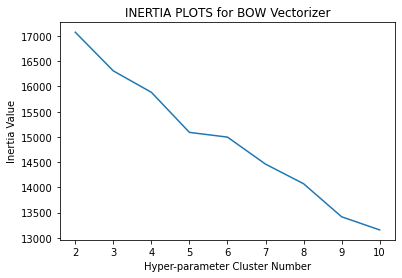

In [26]:
# Plotting Inertia against Number of CLusters
plt.plot(range(2,clusters+1),train_inertia)
plt.title("INERTIA PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Inertia Value')
plt.show()

We see that the optimal cluster number is 5.

We need to plot the Silhouette Score for each cluster also. We need to see if the optimal cluster number found in the above plot give the best silhoutte score too.

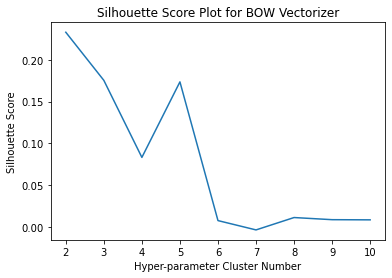

In [27]:
# Plotting Silhouette Score against Number of CLusters
plt.plot(range(2,clusters+1),train_silhouette_score)
plt.title("Silhouette Score Plot for BOW Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Silhouette Score')
plt.show()

We see that the optimal cluster number that Elbow method gave (i.e. 5) is also giving the best silhouette score. 

We can thus choose 5 as the best number of cluster.

We now need to create the KMeans again with 5 clusters.

In [28]:
#Using the random state helps to create the same results
newsDf_finalCluster = KMeans(n_clusters=5, random_state=0)   
    
# Fitting the model
newsDf_finalCluster.fit(kMeans_train_scaled) 

#Getting the final silhouette score for 5 clusters.
silhouette_score = metrics.silhouette_score(kMeans_train_scaled,newsDf_finalCluster.labels_)
print('Silhouette Score for 5 clusters is : ',silhouette_score)

Silhouette Score for 5 clusters is :  0.17358659045238894


In [29]:
#Getting the cluster labels for each record of the corpus.
labels = newsDf_finalCluster.labels_
text_df['Clusters_Label'] = labels
text_df.head(10)

altid                               title  \
0  sa1a70ab8ef5     Davenport hits out at Wimbledon   
1  ta497aea0e36      Camera phones are 'must-haves'   
2  ta0f0fa26a93     US top of supercomputing charts   
3  ba23aaa4f4bb  Trial begins of Spain's top banker   
4  baa126aeb946     Safety alert as GM recalls cars   
5  saa0c6292a37    Angry Williams rejects criticism   
6  pa0f562ea8a2    E-University 'disgraceful waste'   
7  ea6b1e0f27d6   India to deport Bollywood actress   
8  ta74d0c14217  Web radio takes Spanish rap global   
9  babc125887b7   Ailing EuroDisney vows turnaround   

                                             content  \
0   World number one Lindsay Davenport has critic...   
1   Four times more mobiles with cameras in them ...   
2   The US has pushed Japan off the top of the su...   
3   The trial of Emilio Botin, the chairman of Sp...   
4   The world's biggest carmaker General Motors (...   
5   Serena Williams has angrily rejected claims t...   
6   A failed government scheme to offer UK univer...   
7   India has ordered the deportation of Iranian-...   
8   Spin the radio dial in the US and you are lik...   
9   EuroDisney, the European home of Mickey Mouse...   

                                       clean_content  \
0  world number one lindsay davenport criticised ...   
1  four times mobiles cameras sold europe end las...   
2  pushed japan top supercomputing chart ibms pro...   
3  trial emilio botin chairman spains powerful ba...   
4  worlds biggest carmaker general motors recalli...   
5  serena williams angrily rejected claims sister...   
6  failed government scheme offer university cour...   
7  india ordered deportation iranian born model a...   
8  spin radio dial likely find plenty spanish lan...   
9  eurodisney european home mickey mouse friends ...   

                          clean_title  \
0            davenport hits wimbledon   
1           camera phones amust haves   
2           top supercomputing charts   
3      trial begins spains top banker   
4           safety alert recalls cars   
5    angry williams rejects criticism   
6    university wouldisgraceful waste   
7      india deport bollywood actress   
8  web radio takes spanish rap global   
9   ailing eurodisney vows turnaround   

                        combined_clean_content_title  Clusters_Label  
0  world number one lindsay davenport criticised ...               0  
1  four times mobiles cameras sold europe end las...               0  
2  pushed japan top supercomputing chart ibms pro...               0  
3  trial emilio botin chairman spains powerful ba...               0  
4  worlds biggest carmaker general motors recalli...               0  
5  serena williams angrily rejected claims sister...               0  
6  failed government scheme offer university cour...               0  
7  india ordered deportation iranian born model a...               0  
8  spin radio dial likely find plenty spanish lan...               0  
9  eurodisney european home mickey mouse friends ...               0

##### VISUALIZATION OF THE CLUSTERS.

We will create WordCloud for each cluster to see the category of news that are present there. We will also check the density of each clusters.

In [30]:
#Filtering separate datasets for each cluster
final_cluster1 = text_df.loc[text_df['Clusters_Label'] == 1]
final_cluster0 = text_df.loc[text_df['Clusters_Label'] == 0]
final_cluster2 = text_df.loc[text_df['Clusters_Label'] == 2]
final_cluster3 = text_df.loc[text_df['Clusters_Label'] == 3]
final_cluster4 = text_df.loc[text_df['Clusters_Label'] == 4]

We create a dataframe showing the density of each clusters for each algorithms.

In [31]:
cluster_countDF = pd.DataFrame()
cluster_countDF['Cluster_Id'] = range(0,5)
cluster_countDF['KMeans_Count_of_News'] = [len(final_cluster0),len(final_cluster1),len(final_cluster2),len(final_cluster3),len(final_cluster4)]
cluster_countDF.head()

Cluster_Id  KMeans_Count_of_News
0           0                    55
1           1                     1
2           2                     2
3           3                     1
4           4                     1

Plotting the density of each clusters

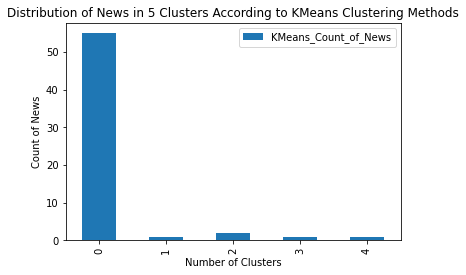

In [32]:
cluster_countDF[['KMeans_Count_of_News']].plot.bar()
plt.title('Distribution of News in 5 Clusters According to KMeans Clustering Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Count of News')
plt.show()

We see that cluster 0 is most dense containing 55 records (out of 60). We are essentially getting one large cluster in KMeans.

This behaviour is true even when we change the number of clusters to 2,3,4 or 6,7 etc.

We are sticking with 5 as 5 clusters gave best silhouette score. We will be using other clustering algorithms also but keeping number of clusters as 5. We can then compare the results of each algorithm by measuring the density of each clusters.

###### CREATING THE WORDCLOUD FOR EACH CLUSTER:

Word CLoud for Cluster 0 :


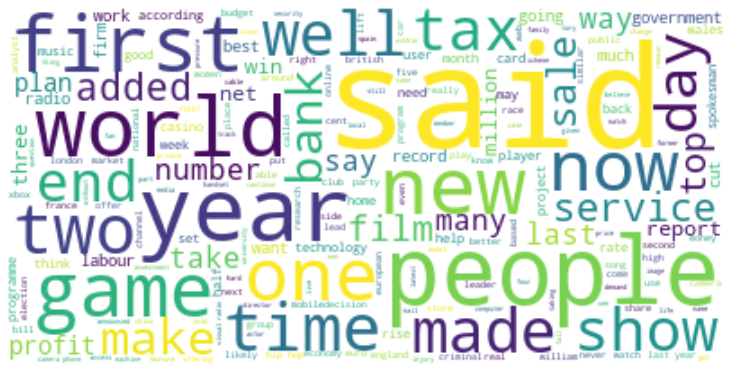

In [33]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(final_cluster0['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The first cluster (cluster0) contains the majority of the records. So we see different topics/cateogories present here. 

For example: 
<br><b> financial news</b> (words like bank,profit,sale,service,firm) </br>, <br><b> entertainment news</b> (words like game,casino,film,music,hip hop) </br>, <br><b> government news</b> (words like tax, government,plan,win,spokesman,work,project) </br>.

Word CLoud for Cluster 1 :


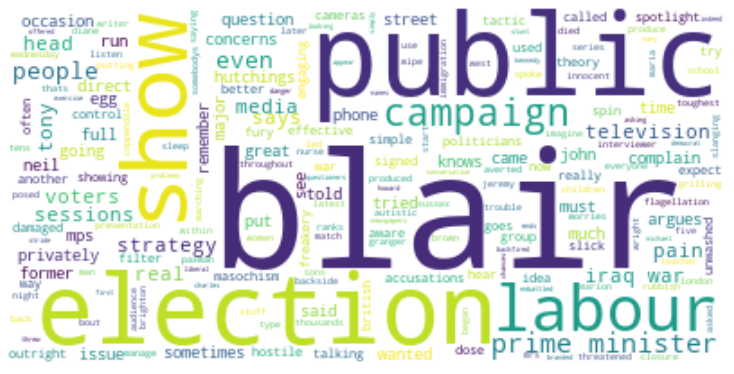

In [34]:
print("Word CLoud for Cluster 1 :")

bow_features = " ".join(final_cluster1['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the second cluster (cluster1), we see that there is only 1 record present. The words present in the wordcloud help us understand the essence of that record only.

From the wordcloud we can say that the record contains <b>election news</b> with words like campaign, election, prime minister, blair (tony blair), election, voters, labour.

Word CLoud for Cluster 2 :


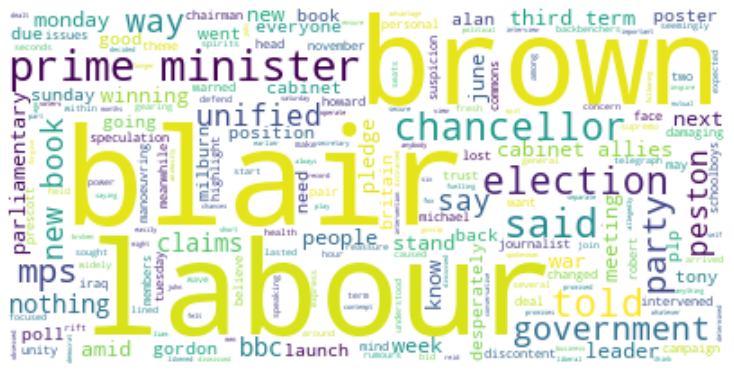

In [35]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(final_cluster2['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the third cluster (cluster2), we see that there are only 2 record present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the records contains <b>government news</b> with words like chancellor, election, prime minister, blair (tony blair), party, brown, bbc, war, government,cabinet, winning, pledge, parliamentary.

Word CLoud for Cluster 3 :


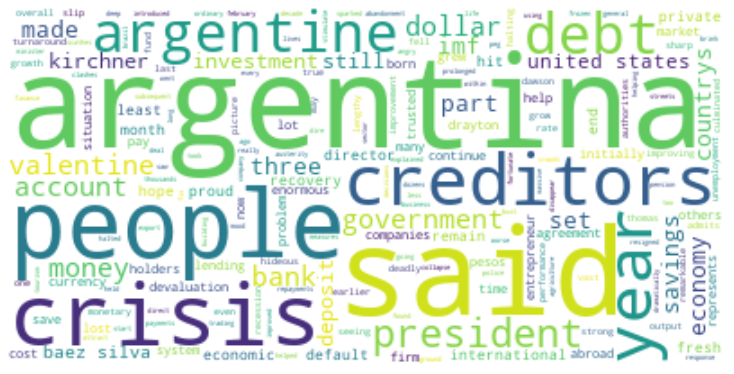

In [36]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(final_cluster3['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the fourth cluster (cluster3), we see that there is again only 1 record present. The words present in the wordcloud help us understand the essence of that record only.

From the wordcloud we can say that the record contains <b>economic news</b> with words like creditors, crisis, people, bank, dollar, debt, account, IMF,  argentina.

Word CLoud for Cluster 4 :


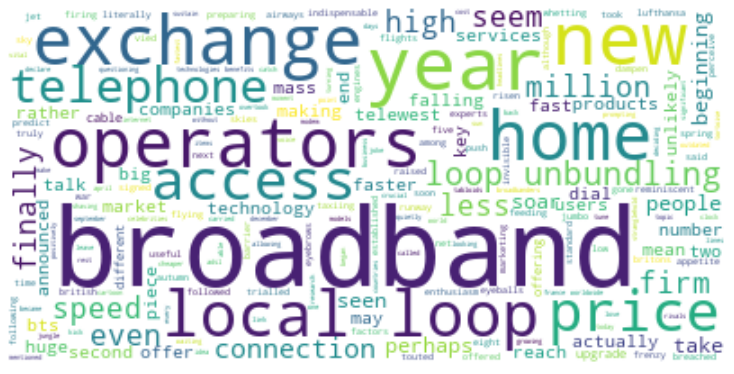

In [37]:
print("Word CLoud for Cluster 4 :")

bow_features = " ".join(final_cluster4['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the fifth and final cluster (cluster4), we see that there is again only 1 record present. The words present in the wordcloud help us understand the essence of that record only.

From the wordcloud we can say that the record contains <b>news related to services offered</b> with words like broadband, operators, price, local, exchange, connection, unbundling, telephone,  home.

###### KMEANS Conclusion:

We see that for KMeans even through the silhouette score is comparitively high but the clusters formed are very different in terms of density. The major cluster contains topics on a variety of news (example: financial, entertainment,government). This is not much ideal. 

Therefore, we will be trying out other clustering algos in order to get more homogenous clusters.

###### 2. FIT NMF (Non Negative Matrix Factorisation) ALGO WITH BAG OF WORDS VECTORIZER:

We are keeping number of clusters as 5 so as to compare the results with KMEANS.

In [38]:
#Load nmf_model with the n_components i.e 5
num_cluster = 5

#Keep the random_state =40 to recreate the results
nmf_model = NMF(n_components=num_cluster, random_state=40)

We need to fit a dense matrix for running the NMF Model. Therefore we are using the dense representation of the Bag of Words vectorizer here. 

In [39]:
#Fitting the dense matrix
nmf_model.fit(newsText_docTermMatrix)

NMF(n_components=5, random_state=40)

We print the top 30 words for each clusters to see how well the clusters are created.

NMF model gives two non-negative matrices W and H (product of W and H is used as approximation of the input corpus to fit method)

In [40]:
#Print the Top 30 words for each of the clusters

#Transforming the corpus with the fitted model
W = nmf_model.transform(newsText_docTermMatrix)

#Vocabulary for each cluster
H = nmf_model.components_ 

#Getting the feature names from bag of words vectorizer
words = np.array(bow_vect.get_feature_names())

#Creating a dataframe to store the top 30 words for each cluster
cluster_words = pd.DataFrame(np.zeros((num_cluster, 30)), index=[f'Cluster {i + 1}' for i in range(num_cluster)],
                           columns=[f'Word {i + 1}' for i in range(30)]).astype(str)

#For each cluster, sorting the vocabulary in descending order and filtering out the top 30 words
for i in range(num_cluster):
    ix = H[i].argsort()[::-1][:30]
    
    #Filling the dataframe with the top 30 words for each cluster
    cluster_words.iloc[i] = words[ix]

#Print the dataframe to visualize the clustering
cluster_words

C:\Users\Namrata Thakur\anaconda3\envs\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Word 1      Word 2    Word 3   Word 4    Word 5      Word 6  \
Cluster 1  growing       users  research  million  services        news   
Cluster 2   labour        said     brown      mps      told  chancellor   
Cluster 3  economy  investment      bank  general    remain      losses   
Cluster 4     play       first      half     side       win       coach   
Cluster 5   public  television  campaign      war      head        tony   

             Word 7       Word 8     Word 9         Word 10  ...   Word 21  \
Cluster 1  software         huge  according        computer  ...       key   
Cluster 2     party     minister      blair  prime minister  ...     stand   
Cluster 3      fell  three years      still          others  ...  interest   
Cluster 4     three       played    england        building  ...   players   
Cluster 5      full        media       even      tony blair  ...     phone   

          Word 22   Word 23          Word 24  Word 25   Word 26 Word 27  \
Cluster 1    said    online              net     idea  internet   music   
Cluster 2  monday   nothing            third  michael       bbc    week   
Cluster 3    said    strong           future      cut       may    part   
Cluster 4     got  pressure             much    world    france   power   
Cluster 5   prime      come  prime ministers   longer     later   great   

                  Word 28    Word 29   Word 30  
Cluster 1          making    include   website  
Cluster 2       secretary       next     going  
Cluster 3            rise      rates     month  
Cluster 4           games  recovered    second  
Cluster 5  prime minister      group  minister  

[5 rows x 30 columns]

The dataframe shows the top 30 words belonging to each cluster. 

We see that the clusters formed are apprearing better as compared to KMeans. We will confirm this inference through the wordcloud visualization.

In [41]:
#Assigning each record in the dataset its corresponding cluster number
text_df['Topic_Modelling'] = W.argmax(axis=1)

In [42]:
#Shape of the transformed data through NMF Algo.
W.shape

(60, 5)

In [43]:
#Re-Confirming that we have 5 unique clusters through NMF Model
text_df["Topic_Modelling"].unique()

array([3, 0, 2, 1, 4], dtype=int64)

In [44]:
#Printing the head to see the modified dataset
text_df.head()

altid                               title  \
0  sa1a70ab8ef5     Davenport hits out at Wimbledon   
1  ta497aea0e36      Camera phones are 'must-haves'   
2  ta0f0fa26a93     US top of supercomputing charts   
3  ba23aaa4f4bb  Trial begins of Spain's top banker   
4  baa126aeb946     Safety alert as GM recalls cars   

                                             content  \
0   World number one Lindsay Davenport has critic...   
1   Four times more mobiles with cameras in them ...   
2   The US has pushed Japan off the top of the su...   
3   The trial of Emilio Botin, the chairman of Sp...   
4   The world's biggest carmaker General Motors (...   

                                       clean_content  \
0  world number one lindsay davenport criticised ...   
1  four times mobiles cameras sold europe end las...   
2  pushed japan top supercomputing chart ibms pro...   
3  trial emilio botin chairman spains powerful ba...   
4  worlds biggest carmaker general motors recalli...   

                      clean_title  \
0        davenport hits wimbledon   
1       camera phones amust haves   
2       top supercomputing charts   
3  trial begins spains top banker   
4       safety alert recalls cars   

                        combined_clean_content_title  Clusters_Label  \
0  world number one lindsay davenport criticised ...               0   
1  four times mobiles cameras sold europe end las...               0   
2  pushed japan top supercomputing chart ibms pro...               0   
3  trial emilio botin chairman spains powerful ba...               0   
4  worlds biggest carmaker general motors recalli...               0   

   Topic_Modelling  
0                3  
1                0  
2                3  
3                3  
4                2

We group the dataset based on the nmf clusters to inspect some of the news (5) belonging to each clusters.

In [45]:
text_df_group=text_df.groupby('Topic_Modelling').head(5)
text_df_group.sort_values('Topic_Modelling')

altid                               title  \
54  tf1c44c2dda9     Yahoo moves into desktop search   
1   ta497aea0e36      Camera phones are 'must-haves'   
52  tfc79e39b792    Apple iPod family expands market   
43  ted5fdd4d954             Broadband soars in 2004   
53  tf1ca407d243     Iran jails blogger for 14 years   
34  pda9f0bd8144    Lib Dems stress Budget trust gap   
33  pda7a4b979ac   Nat Insurance to rise, say Tories   
31  pd0f0fa26a93   Howard denies split over ID cards   
25  pc463fa57b3d     New UKIP defection to 'Veritas'   
32  pdf35f8013b5   Blair pledges unity to Labour MPs   
6   pa0f562ea8a2    E-University 'disgraceful waste'   
4   baa126aeb946     Safety alert as GM recalls cars   
41  be5096b9ddfe   Standard Life cuts policy bonuses   
42  bebea492cd2f    Cars pull down US retail figures   
9   babc125887b7   Ailing EuroDisney vows turnaround   
7   ea6b1e0f27d6   India to deport Bollywood actress   
5   saa0c6292a37    Angry Williams rejects criticism   
3   ba23aaa4f4bb  Trial begins of Spain's top banker   
2   ta0f0fa26a93     US top of supercomputing charts   
0   sa1a70ab8ef5     Davenport hits out at Wimbledon   
30  pd8e14207069         Analysis: No pain, no gain?   
37  pd6565c7946e            PM apology over jailings   
46  be708dc73ba5    Huge rush for Jet Airways shares   
50  tfaa05f305c2   Local net TV takes off in Austria   
51  tfce2b61b8bd   Rich pickings for hi-tech thieves   

                                              content  \
54   Internet giant Yahoo has launched software to...   
1    Four times more mobiles with cameras in them ...   
52   Apple has expanded its iPod family with the r...   
43   If broadband were a jumbo jet, then 2003 woul...   
53   An Iranian weblogger has been jailed for 14 y...   
34   Public trust in the handling of the economy c...   
33   National Insurance will be raised if Labour w...   
31   Michael Howard has denied his shadow cabinet ...   
25   The UK Independence Party has lost one of its...   
32   Tony Blair has sought to reassure Labour back...   
6    A failed government scheme to offer UK univer...   
4    The world's biggest carmaker General Motors (...   
41   Standard Life, Europe's largest mutual life i...   
42   US retail sales fell 0.3% in January, the big...   
9    EuroDisney, the European home of Mickey Mouse...   
7    India has ordered the deportation of Iranian-...   
5    Serena Williams has angrily rejected claims t...   
3    The trial of Emilio Botin, the chairman of Sp...   
2    The US has pushed Japan off the top of the su...   
0    World number one Lindsay Davenport has critic...   
30   He called it his "masochism strategy" in the ...   
37   Tony Blair has apologised to two families who...   
46   Indian airline Jet Airways' initial public of...   
50   An Austrian village is testing technology tha...   
51   Viruses, trojans and other malicious programs...   

                                        clean_content  \
54  internet giant yahoo launched software allow p...   
1   four times mobiles cameras sold europe end las...   
52  apple expanded ipod family release next genera...   
43  broadband jumbo jet seen taxiing runway firing...   
53  iranian weblogger jailed years charges spying ...   
34  public trust handling economy restored gordon ...   
33  national insurance raised labour wins next ele...   
31  michael howard denied shadow cabinet split dec...   
25  independence party lost one two london assembl...   
32  tony blair sought reassure labour backbenchers...   
6   failed government scheme offer university cour...   
4   worlds biggest carmaker general motors recalli...   
41  standard life europes largest mutual life insu...   
42  retail sales fell january biggest monthly decl...   
9   eurodisney european home mickey mouse friends ...   
7   india ordered deportation iranian born model a...   
5   serena williams angrily rejected claims sister...   
3   trial emilio botin chairman spains powerf

##### VISUALIZATION OF THE CLUSTERS.

We will create WordCloud for each cluster to see the category of news that are present there. We will also check the density of each clusters.

In [46]:
#Filtering separate datasets for each cluster
topic_cluster1 = text_df.loc[text_df['Topic_Modelling'] == 1]
topic_cluster0 = text_df.loc[text_df['Topic_Modelling'] == 0]
topic_cluster2 = text_df.loc[text_df['Topic_Modelling'] == 2]
topic_cluster3 = text_df.loc[text_df['Topic_Modelling'] == 3]
topic_cluster4 = text_df.loc[text_df['Topic_Modelling'] == 4]

We append the density of each clusters for NMF algorithm to the dataframe.

In [47]:
cluster_countDF['NMF_Count_of_News'] = [len(topic_cluster0),len(topic_cluster1),len(topic_cluster2),
                                        len(topic_cluster3),len(topic_cluster4)]
cluster_countDF.head()

Cluster_Id  KMeans_Count_of_News  NMF_Count_of_News
0           0                    55                  8
1           1                     1                  9
2           2                     2                 10
3           3                     1                 28
4           4                     1                  5

Plotting the density of each clusters

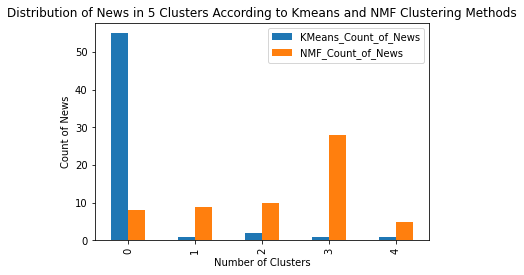

In [48]:
cluster_countDF[['KMeans_Count_of_News','NMF_Count_of_News']].plot.bar()
plt.title('Distribution of News in 5 Clusters According to Kmeans and NMF Clustering Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Count of News')
plt.show()

We see that the density of the clusters formed through NMF are spread quite evenly. The first 3 clusters are having near equal number of records and the fourth cluster contains the maximum number of records (27). 

We can thus see that the content of the one major cluster of KMEANS are seggregated near equally to 5 clusters. We can presume that the different news categories present in the one big cluster of KMEANS are now separated and they belong to their individual clusters. 

We can check this inference by visualizing the wordcloud.

###### CREATING THE WORDCLOUD FOR EACH CLUSTER:

Word CLoud for Cluster 0 :


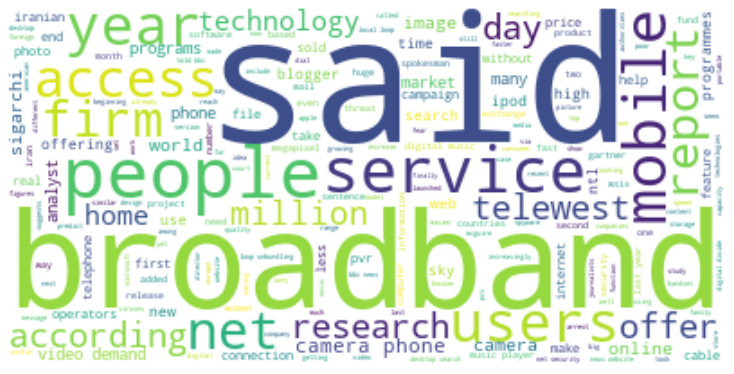

In [49]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(topic_cluster0['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the first cluster (cluster0), we see that there are 11 records present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to techonology</b> with words like broadband, service, users, mobile, technology, net, programme, people,  home.

Word CLoud for Cluster 1 :


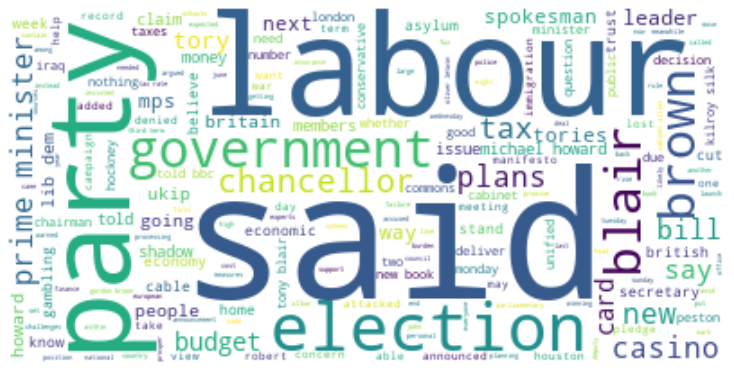

In [50]:
print("Word CLoud for Cluster 1 :")

bow_features = " ".join(topic_cluster1['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the second cluster (cluster1), we see that there are 9 records present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to government</b> with words like government, labour, chancellor, party, election, blair (tony blair), tax, leader, prine minister.

Word CLoud for Cluster 2 :


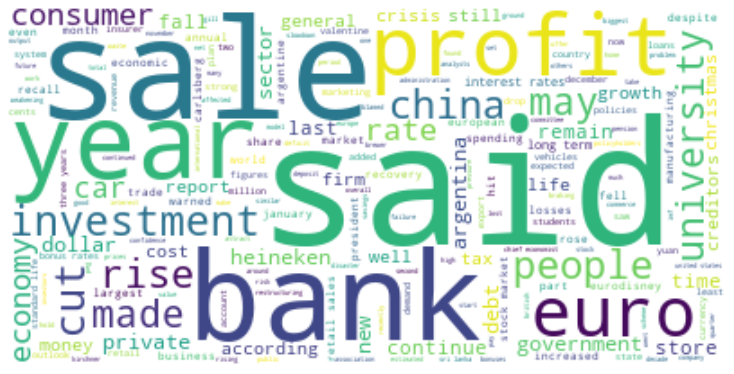

In [51]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(topic_cluster2['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the third cluster (cluster2), we see that there are 10 records present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to finance and economy</b> with words like bank, sale, profit, investment, year, euro, debt, creditors, economy.

Word CLoud for Cluster 3 :


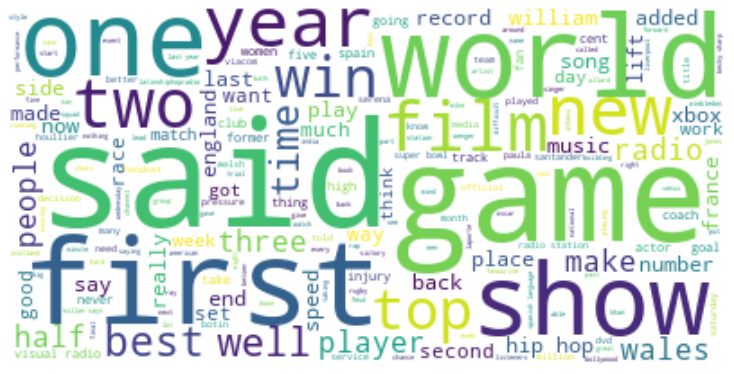

In [52]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(topic_cluster3['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the fourth cluster (cluster3), we see that there are 27 records present. This is the largest cluster created through nmf model. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to games and entertainment</b> with words like world game, show, best film, win, player, hip hop, race, radio, xbox, music.

Word CLoud for Cluster 4 :


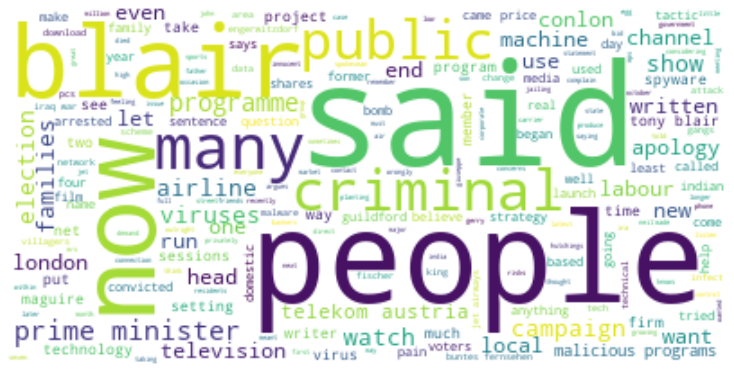

In [53]:
print("Word CLoud for Cluster 4 :")

bow_features = " ".join(topic_cluster4['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the fifth and final cluster (cluster4), we see that there are only 3 records present. This is the smnallest cluster created through nmf model. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to a crisis event</b> with words like blair, voters, election, airline, bomb, apology, media, london, arrested, pain, public, convicted, iraq war.

###### NMF Conclusion:

We see that for NMF the clusters formed are very different from each other. Alongside, the records present in each clusters are essentially communicating a particular type of news only. This is an ideal situation where inter-cluster dissimilarity is high as well as intra-cluster similarity is high.

For 5 clusters, we get 5 categories of news namely:
- 1) Technology
- 2) Government
- 3) Economy
- 4) Entertainment
- 5) Crisis Event

The clusters thus formed are quite homogenous.

###### 3. FIT AGGLOMERATIVE CLUSTERING ALGO WITH TF-IDF VECTORIZER:

We are fitting a TF-IDF Vectorizer with unigram, bigram and trigram words (ngram_range) and selecting words only if they occur atleast 5 times (min_df) in the vocabulary. In this way, we can restrict our vocabulary to more frequent and important words. Also, this helps us in getting a lower dimension that is helpful for the clustering algo.

In [54]:
#Creating the Tf-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,3) , min_df = 5)

#Fitting the vectorizer to the corpus to get the vobulary and then transform the corpus using that vocabulary
agglo_clusterTrain = tfidf_vect.fit_transform(text_df['combined_clean_content_title'])

#Printing 20 feature names of Tf-idf vectorizer
print("Some feature names : ", tfidf_vect.get_feature_names()[0:20])

#Getting the shape of the vectorized corpus
print(agglo_clusterTrain.shape)

Some feature names :  ['able', 'access', 'according', 'accused', 'across', 'added', 'ago', 'agreed', 'allow', 'almost', 'already', 'although', 'always', 'american', 'among', 'analysts', 'announced', 'annual', 'another', 'anything']
(60, 404)


C:\Users\Namrata Thakur\anaconda3\envs\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


We get a total of 404 features from Tf-IDF vectoriser.

In [55]:
#Creating the StandardScaler
scaler = StandardScaler(with_mean=False)

#Fitting the scaler on the dataset to learn the standard-deviation
scaler.fit(agglo_clusterTrain)

#Transforming the corpus with the appropiate mean and standard deviation (as found in standard scaler)
agglo_clusterTrain_scaled = scaler.transform(agglo_clusterTrain)

#Checking the shape. It should remain same.
print(agglo_clusterTrain_scaled.shape)

(60, 404)


We need to standardise the data because Agglomerative clustering uses a distance metric (example: euclidean distance) to create the clusters. Distance metrics are heavily impacted by non-standardised data.

In [56]:
#Creating a document term matrix or visualising the vectorised data. 
newsText_TfIdf_docTermMatrix = pd.DataFrame(agglo_clusterTrain_scaled.toarray(), columns = tfidf_vect.get_feature_names())
newsText_TfIdf_docTermMatrix.head()

able  access  according   accused  across     added  ago  agreed  \
0  6.884997     0.0   0.000000  0.000000     0.0  3.364226  0.0     0.0   
1  0.000000     0.0   2.765708  0.000000     0.0  0.000000  0.0     0.0   
2  0.000000     0.0   0.000000  0.000000     0.0  0.000000  0.0     0.0   
3  0.000000     0.0   0.000000  4.986342     0.0  0.000000  0.0     0.0   
4  0.000000     0.0   3.104485  0.000000     0.0  0.000000  0.0     0.0   

      allow  almost  ...   without      work     world    worlds  written  \
0  0.000000     0.0  ...  0.000000  0.000000  1.060912  0.000000      0.0   
1  0.000000     0.0  ...  0.000000  1.231018  0.727835  0.000000      0.0   
2  0.000000     0.0  ...  2.414826  1.514615  1.791021  0.000000      0.0   
3  0.000000     0.0  ...  0.000000  0.000000  0.000000  0.000000      0.0   
4  4.927471     0.0  ...  0.000000  2.763615  0.000000  4.995519      0.0   

       year     years  years ago  yet  young  
0  0.000000  0.000000        0.0  0.0    0.0  
1  0.620201  0.000000        0.0  0.0    0.0  
2  2.289240  0.000000        0.0  0.0    0.0  
3  0.000000  1.790965        0.0  0.0    0.0  
4  2.784681  4.922049        0.0  0.0    0.0  

[5 rows x 404 columns]

We need to fit a dense matrix to Agglomerative Clustering model. Therefore we are creating the above dataframe.

##### Fitting AGGLOMERATIVE CLUSTERING Algo on TF-IDF transformed data:

In [57]:
#Selecting hyper-parameter value
clusters = 10

#Creating a list to contain the silhouette scores for each hyper-parameter
train_silhouette_score = []

#Iterating for each value of hyper-parameter
for i in tqdm(range(2,clusters+1)):
    
    #Creating the AgglomerativeClustering object for each cluster
    agglo = AgglomerativeClustering(n_clusters=i)
      
    #Fitting the AgglomerativeClustering on the Tf-Idf Scaled Data and getting the cluster labels
    labels = agglo.fit_predict(newsText_TfIdf_docTermMatrix)
    
    #Getting the silhouette score for the labels
    silhouette_score = metrics.silhouette_score(agglo_clusterTrain_scaled, labels)
    
    #Printing the silhouette score for each cluster
    print("For n_clusters =",i,"The average silhouette_score is :",silhouette_score)
    
    #Appending the silhouette score to the list
    train_silhouette_score.append(silhouette_score)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.86it/s]

For n_clusters = 2 The average silhouette_score is : 0.01916222008104263
For n_clusters = 3 The average silhouette_score is : 0.021800284863785595
For n_clusters = 4 The average silhouette_score is : 0.027099605052151438
For n_clusters = 5 The average silhouette_score is : 0.024755195840419096
For n_clusters = 6 The average silhouette_score is : 0.025128623021982478
For n_clusters = 7 The average silhouette_score is : 0.026228036386594766
For n_clusters = 8 The average silhouette_score is : 0.02838647879118661
For n_clusters = 9 The average silhouette_score is : 0.023179508375755213
For n_clusters = 10 The average silhouette_score is : 0.021100675270425442


We did hyper-parameter tuning of the cluster numbers during training. We need to get the optimal cluster number.

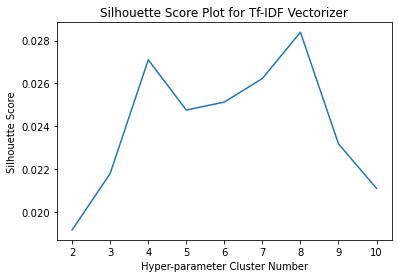

In [58]:
# Plotting Silhouette Score against Number of CLusters
plt.plot(range(2,clusters+1),train_silhouette_score)
plt.title("Silhouette Score Plot for Tf-IDF Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Silhouette Score')
plt.show()

We see that the optimal cluster number came as 4 and 8 that is giving the best silhouette score. 

We having been using number of clusters as 5 till now for KMEANS and NMF. In Agglomerative Clustering we see that the silhouette score for 5 clusters is not much different from that of 4 or 8 clusters.

Therefore we will be selecting optimal cluster number as 5 so that we can better compare the results with other algorithms.

We now need to create the Agglomerative Cluster again with 5 clusters.

In [59]:
# Fitting the model
aggloCluster = AgglomerativeClustering(n_clusters=5)
aggloCluster.fit(agglo_clusterTrain_scaled.toarray())

#Getting the final silhouette score for 5 clusters.
agglo_score = metrics.silhouette_score(agglo_clusterTrain_scaled, aggloCluster.labels_)
print('Silhouette Score for Agglomerative Clustering with 5 clusters : ',agglo_score)

Silhouette Score for Agglomerative Clustering with 5 clusters :  0.024755195840419096


In [60]:
#Getting the cluster labels for each record of the corpus.
labels = aggloCluster.labels_
text_df['Agglomerative_Label'] = labels
text_df.head(10)

altid                               title  \
0  sa1a70ab8ef5     Davenport hits out at Wimbledon   
1  ta497aea0e36      Camera phones are 'must-haves'   
2  ta0f0fa26a93     US top of supercomputing charts   
3  ba23aaa4f4bb  Trial begins of Spain's top banker   
4  baa126aeb946     Safety alert as GM recalls cars   
5  saa0c6292a37    Angry Williams rejects criticism   
6  pa0f562ea8a2    E-University 'disgraceful waste'   
7  ea6b1e0f27d6   India to deport Bollywood actress   
8  ta74d0c14217  Web radio takes Spanish rap global   
9  babc125887b7   Ailing EuroDisney vows turnaround   

                                             content  \
0   World number one Lindsay Davenport has critic...   
1   Four times more mobiles with cameras in them ...   
2   The US has pushed Japan off the top of the su...   
3   The trial of Emilio Botin, the chairman of Sp...   
4   The world's biggest carmaker General Motors (...   
5   Serena Williams has angrily rejected claims t...   
6   A failed government scheme to offer UK univer...   
7   India has ordered the deportation of Iranian-...   
8   Spin the radio dial in the US and you are lik...   
9   EuroDisney, the European home of Mickey Mouse...   

                                       clean_content  \
0  world number one lindsay davenport criticised ...   
1  four times mobiles cameras sold europe end las...   
2  pushed japan top supercomputing chart ibms pro...   
3  trial emilio botin chairman spains powerful ba...   
4  worlds biggest carmaker general motors recalli...   
5  serena williams angrily rejected claims sister...   
6  failed government scheme offer university cour...   
7  india ordered deportation iranian born model a...   
8  spin radio dial likely find plenty spanish lan...   
9  eurodisney european home mickey mouse friends ...   

                          clean_title  \
0            davenport hits wimbledon   
1           camera phones amust haves   
2           top supercomputing charts   
3      trial begins spains top banker   
4           safety alert recalls cars   
5    angry williams rejects criticism   
6    university wouldisgraceful waste   
7      india deport bollywood actress   
8  web radio takes spanish rap global   
9   ailing eurodisney vows turnaround   

                        combined_clean_content_title  Clusters_Label  \
0  world number one lindsay davenport criticised ...               0   
1  four times mobiles cameras sold europe end las...               0   
2  pushed japan top supercomputing chart ibms pro...               0   
3  trial emilio botin chairman spains powerful ba...               0   
4  worlds biggest carmaker general motors recalli...               0   
5  serena williams angrily rejected claims sister...               0   
6  failed government scheme offer university cour...               0   
7  india ordered deportation iranian born model a...               0   
8  spin radio dial likely find plenty spanish lan...               0   
9  eurodisney european home mickey mouse friends ...               0   

   Topic_Modelling  Agglomerative_Label  
0                3                    0  
1                0                    2  
2                3                    2  
3                3                    0  
4                2                    1  
5                3                    0  
6                2                    1  
7                3                    0  
8                3                    2  
9                2                    0

##### VISUALIZATION OF THE CLUSTERS.

We will create WordCloud for each cluster to see the category of news that are present there. We will also check the density of each clusters.

In [61]:
#Filtering separate datasets for each cluster
agglo_cluster1 = text_df.loc[text_df['Agglomerative_Label'] == 1]
agglo_cluster0 = text_df.loc[text_df['Agglomerative_Label'] == 0]
agglo_cluster2 = text_df.loc[text_df['Agglomerative_Label'] == 2]
agglo_cluster3 = text_df.loc[text_df['Agglomerative_Label'] == 3]
agglo_cluster4 = text_df.loc[text_df['Agglomerative_Label'] == 4]

We append the density of each clusters for NMF algorithm to the dataframe.

In [62]:
cluster_countDF['Agglo_Count_of_News'] = [len(agglo_cluster0),len(agglo_cluster1),len(agglo_cluster2),
                                        len(agglo_cluster3),len(agglo_cluster4)]
cluster_countDF.head()

Cluster_Id  KMeans_Count_of_News  NMF_Count_of_News  Agglo_Count_of_News
0           0                    55                  8                   19
1           1                     1                  9                   13
2           2                     2                 10                   15
3           3                     1                 28                   10
4           4                     1                  5                    3

Plotting the density of each clusters

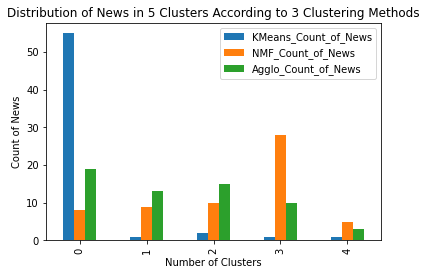

In [63]:
cluster_countDF[['KMeans_Count_of_News','NMF_Count_of_News','Agglo_Count_of_News']].plot.bar()
plt.title('Distribution of News in 5 Clusters According to 3 Clustering Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Count of News')
plt.show()

We see that the density of the clusters formed through Agglomerative Clustering are spread quite evenly. The first cluster contains the maximum number of records (19). Inspite of this, the density of this cluster is nearly same with respect to that of the other clusters. The next 3 clusters are having near equal number of records and the fifth cluster contains the minimum number of records (3). 

We can thus see that the content of the one major cluster of KMEANS are again seggregated near equally to 5 clusters. We can presume that the different news categories present in the one big cluster of KMEANS are now separated and they belong to their individual clusters. 

We can check this inference by visualizing the wordcloud.

###### CREATING THE WORDCLOUD FOR EACH CLUSTER:

Word CLoud for Cluster 0 :


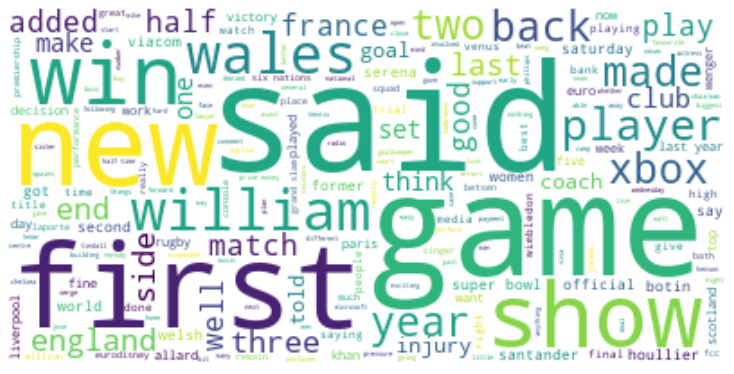

In [64]:
print("Word CLoud for Cluster 0 :")

tfidf_features = " ".join(agglo_cluster0['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(tfidf_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the first cluster (cluster0), we see that there are 19 records present. This is the largest cluster created through agglomerative model. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to games</b> with words like game, show, match, first win, player, last injury, england, wales, xbox, coach.

Word CLoud for Cluster 1 :


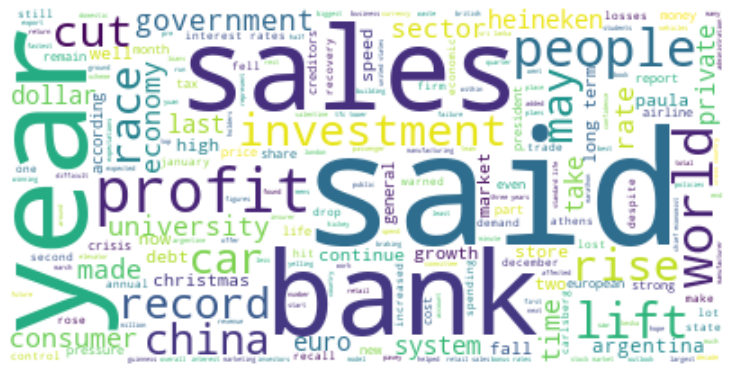

In [65]:
print("Word CLoud for Cluster 1 :")

tfidf_features = " ".join(agglo_cluster1['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(tfidf_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the second cluster (cluster1), we see that there are 13 records present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to finance and economy</b> with words like sales, profit, bank, world investment, economy, government, consumer, record, dollar, china, argentina.

Word CLoud for Cluster 2 :


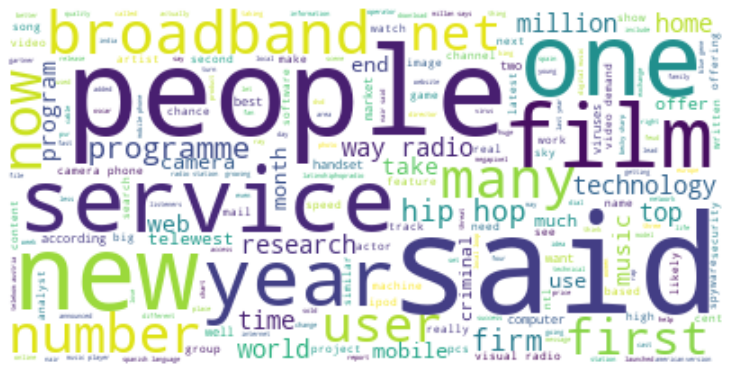

In [66]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(agglo_cluster2['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the third cluster (cluster2), we see that there are 15 records present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to technology and entertainment</b> with words like broadband, service, technology, one film, radio, hip hop, camera, computer, handset, music.

Word CLoud for Cluster 3 :


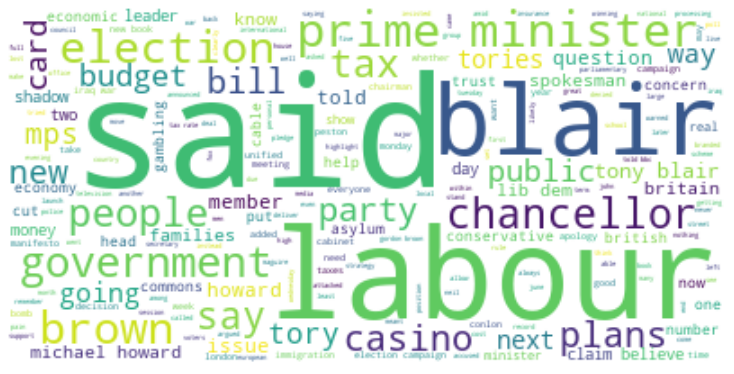

In [67]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(agglo_cluster3['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the fourth cluster (cluster3), we see that there are 10 records present. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to government</b> with words like labour, blair, prime minister, party, public, chancellor, tax, government, bill, budget.

Word CLoud for Cluster 4 :


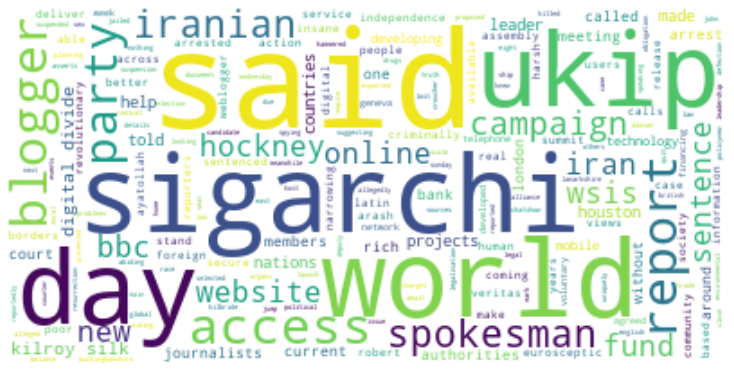

In [68]:
print("Word CLoud for Cluster 4 :")

bow_features = " ".join(agglo_cluster4['combined_clean_content_title'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

For the fifth and final cluster (cluster4), we see that there are only 3 records present. This is the smnallest cluster created through agglomerative model. The words present in the wordcloud help us understand the essence of those records only.

From the wordcloud we can say that the record contains <b>news related to miscellenous variety</b> with words like sigarchi, campaign, bbc, world, party, hockey, website, spokesman, iran, online. 

This news is mostly about Sigarchi, an iranian blogger and journalist.



###### Agglomerative Clustering Conclusion:

We see that for Agglomerative clustering, the clusters formed are very different from each other. Alongside, the records present in each clusters are essentially communicating a particular type of news only. This is an ideal situation where inter-cluster dissimilarity is high as well as intra-cluster similarity is high.

For 5 clusters, we get 5 categories of news namely:
- 1) Entertainment and Technology
- 2) Government
- 3) Economy
- 4) Games
- 5) Miscelleneous Variety

The clusters thus formed are quite homogenous.

## FINAL CONCLUSION:

We tried 3 different clustering algorithms namely KMEANS, NMF, and AGGLOMERATIVE CLUSTERING.

- <b><u>1) KMEANS:</u></b> 
It has compartively higher silhouette score than the rest. But it is clustering nearly all the news into one single cluster. Alongside, the news present in different clusters are also sometimes of the same category. For example: The major cluster (cluster0) contains government news as well as the smaller clusters (cluster1 and cluster2) also contain records relating to election and government news. 

Therefore, we see that the <b>intra-cluster similarity is low </b> (considering different categories of news present together) and <b>inter-cluster dissimilarity is also low</b>. This is not an ideal scenario. 

<b><u>Therefore, we will NOT consider KMEANS as our final solution to this problem task.</u></b>


- <b><u>2) NMF:</u></b>
We see that for NMF the clusters formed are very different from each other. Alongside, the records present in each clusters are essentially communicating a particular type of news only. 

This is an ideal situation where <b>inter-cluster dissimilarity is high</b> as well as <b>intra-cluster similarity is high</b>.

For 5 clusters, we get 5 categories of news namely:
- 1) Technology
- 2) Government
- 3) Economy
- 4) Entertainment
- 5) Crisis Event

The clusters thus formed are quite homogenous.

<b><u>Therefore, we can consider NMF as one of the contendors for our final solution to this problem task.</u></b> 
    
- <b><u>3) AGGLOMERATIVE CLUSTERING:</u></b>

We see that for Agglomerative clustering, the clusters formed are again very different from each other. Alongside, the records present in each clusters are essentially communicating a particular type of news only. This is again an ideal situation where <b>inter-cluster dissimilarity is high</b> as well as <b>intra-cluster similarity is high</b>.

For 5 clusters, we get 5 categories of news namely:
- 1) Entertainment and Technology
- 2) Government
- 3) Economy
- 4) Games
- 5) Miscellaneous Variety

The clusters thus formed are quite homogenous. 

But we see some negative points here as mentioned below:
- We see that Entertainment and Technology news are grouped into one cluster. These two are widely different categories of news.

- Alternatively, Games and Entertainment should more likely be grouped together because the essence of news pertaining to these categories are more likely to be similar.

- Miscellenous Variety category is pertaining to news about a single person (most probably). This sort of particularity generally overfits the model.

========================================================================================================================

Such behaviour is not present in the clusters created by NMF where each category news is quite distinct in themselves. 

Moreover the 5th Cluster of NMF is pertaining to news related to crisis events like war (given words like iraq war) and terrorist attack (given words like domestic airplane, convicted, arrested etc). It is not focusing on one particular event or person, therefore the scope of model overfitting in the NMF model is low.


<b><u>Therefore, we are considering NMF as our final solution to this problem task.</u></b>